In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
!pip install nvcc4jupyter

In [3]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpupvwh00k".


In [6]:
%%cuda
#include <iostream>
#include <cuda_runtime.h>
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <chrono>

const int sizeArr = 5;
const int sizes[sizeArr]{100, 250, 500, 1000, 2000};

// Cuda ядро умножения матриц
__global__ void cuda_mat_mul(const int* A, const int* B, int* C, int n) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < n && col < n)
	  {
        int sum = 0;
        for (int i = 0; i < n; ++i)
		    {
            sum += A[row * n + i] * B[i * n + col];
        }
        C[row * n + col] = sum;
    }
}

// Функция умножения матриц на ЦП
void cpu_matrix_mult(const int *h_a, const int *h_b, int *h_result, int n) {
    for (int i = 0; i < n; ++i)
    {
        for (int j = 0; j < n; ++j)
        {
            int tmp = 0.0;
            for (int k = 0; k < n; ++k)
            {
                tmp += h_a[i * n + k] * h_b[k * n + j];
            }
            h_result[i * n + j] = tmp;
        }
    }
}

// Функция умножения матриц на ГП
void gpu_matrix_mult(const int* A, const int* B, int* C, int n) {
    int* d_A, * d_B, * d_C;
    size_t size = n * n * sizeof(int);

    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B, size, cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((n + threadsPerBlock.x - 1) / threadsPerBlock.x,
        (n + threadsPerBlock.y - 1) / threadsPerBlock.y);

    cuda_mat_mul<<<blocksPerGrid, threadsPerBlock>>> (d_A, d_B, d_C, n);

    cudaMemcpy(C, d_C, size, cudaMemcpyDeviceToHost);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
}

// Функция запуска опредеденной функции умножения матрицы с засечением времени
void measureTime(void(*func)(const int*, const int*, int*, int), const int* A, const int* B, int* C, int n, const char* description)
{
    auto start = std::chrono::high_resolution_clock::now();
    func(A, B, C, n);
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> diff = end - start;
    printf("%s took %f seconds, size = %d\n", description, diff.count(), n);
}

// Функция сравнения матриц
bool compareMatrices(const int* A, const int* B, int n) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            if (A[i * n + j] != B[i * n + j]) return false;
        }
    }
    return true;
}

int main()
{
    for (int n = 0; n < sizeof(sizes) / sizeof(sizes[n]); n++)
    {
        int N = sizes[n];

        int* A = new int[N * N];
        int* B = new int[N * N];
        int* C = new int[N * N];
        int* C_CPU = new int[N * N];

        for (int i = 0; i < N * N; i++)
	      {
            A[i] = rand() % 10;
            B[i] = rand() % 10;
        }

        measureTime(gpu_matrix_mult, A, B, C, N, "CUDA");
        measureTime(cpu_matrix_mult, A, B, C_CPU, N, "CPU");

        if (compareMatrices(C, C_CPU, N))
	      {
            printf("Results are correct!\n");
        }	else
	      {
            printf("Results are incorrect!\n");
        }

        delete[] A;
        delete[] B;
        delete[] C;
        delete[] C_CPU;
    }


    return 0;
}

CUDA took 0.103675 seconds, size = 100
CPU took 0.002803 seconds, size = 100
Results are correct!
CUDA took 0.000715 seconds, size = 250
CPU took 0.043189 seconds, size = 250
Results are correct!
CUDA took 0.002956 seconds, size = 500
CPU took 0.466799 seconds, size = 500
Results are correct!
CUDA took 0.012641 seconds, size = 1000
CPU took 3.807874 seconds, size = 1000
Results are correct!
CUDA took 0.078518 seconds, size = 2000
CPU took 62.446096 seconds, size = 2000
Results are correct!



Размер 	 Время на CPU 	 Время на GPU 	 Ускорение
100 	 0.002803 	 0.103675 	 0.02703641186399807
250 	 0.043189 	 0.000715 	 60.4041958041958
500 	 0.466799 	 0.002956 	 157.91576454668473
1000 	 3.807874 	 0.012641 	 301.23202278300766
2000 	 62.446096 	 0.078518 	 795.3093048727679


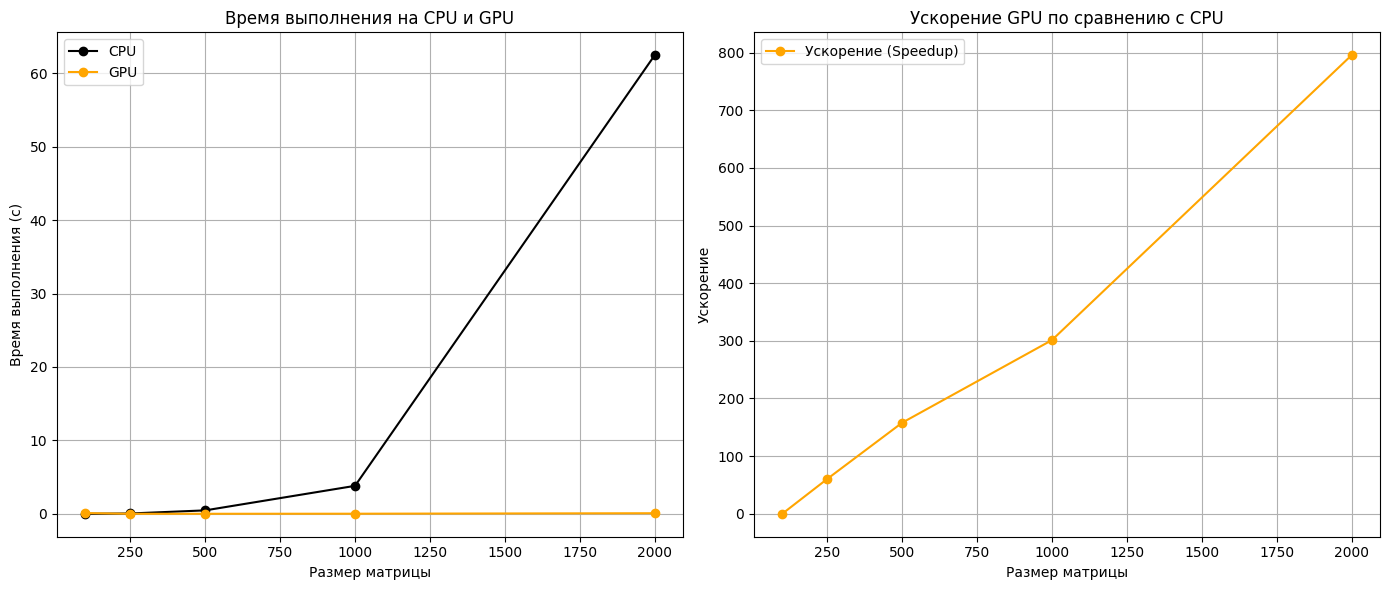

In [9]:
import matplotlib.pyplot as plt

sizes = [100, 250, 500, 1000, 2000]
times_cpu = [0.002803, 0.043189, 0.466799, 3.807874, 62.446096]
times_gpu = [0.103675, 0.000715, 0.002956, 0.012641, 0.078518]
speedups = [a/b for a,b in zip(times_cpu, times_gpu)]
print("Размер \t Время на CPU \t Время на GPU \t Ускорение")
for i in range (len(sizes)):
  print(f"{sizes[i]} \t {times_cpu[i]} \t {times_gpu[i]} \t {speedups[i]}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(sizes, times_cpu, label="CPU", marker="o", color="black")
plt.plot(sizes, times_gpu, label="GPU", marker="o", color="orange")
plt.xlabel("Размер матрицы")
plt.ylabel("Время выполнения (с)")
plt.title("Время выполнения на CPU и GPU")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sizes, speedups, label="Ускорение (Speedup)", marker="o", color="orange")
plt.xlabel("Размер матрицы")
plt.ylabel("Ускорение")
plt.title("Ускорение GPU по сравнению с CPU")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()